In [1]:
import sys
from pandas import value_counts
import pickle
import numpy as np
from imblearn.over_sampling import SMOTE
from numpy import array, ndarray
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from scipy.stats import norm, expon, lognorm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, \
  CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multiline_chart, plot_evaluation_results, \
  plot_horizontal_bar_chart, HEIGHT, plot_line_chart, dummify, run_NB, run_KNN, plot_multibar_chart, \
  encode_cyclic_variables, plot_confusion_matrix, NR_STDEV, determine_outlier_thresholds_for_var
from studies import naive_Bayes_study, knn_study, evaluate_approach, evaluate_and_plot 


### **Outliers** ###

In [2]:
file_tag = "traffic"
lab_folder_out = "lab3_preparation/outliers"
target_name = "crash_type"
filename = "../../data/prepared/traffic_enc1.csv"
# filename = "../../data/prepared/traffic_enc2.csv"
data: DataFrame = read_csv(filename, na_values="")
variable_types: dict[str, list] = get_variable_types(data)
# data.shape

### Approach 1 ###

In [3]:
approach_out1 = "drop_outliers"

In [4]:
n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df_out1: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var]
        )
        outliers: Series = df_out1[(df_out1[var] > top_threshold) | (df_out1[var] < bottom_threshold)]
        df_out1.drop(outliers.index, axis=0, inplace=True)
    df_out1.to_csv(f"../../data/prepared/{file_tag}_{approach_out1}.csv", index=True)
    print(f"Data after dropping outliers: {df_out1.shape}")
else:
    print("There are no numeric variables")

Data after dropping outliers: (138419, 150)


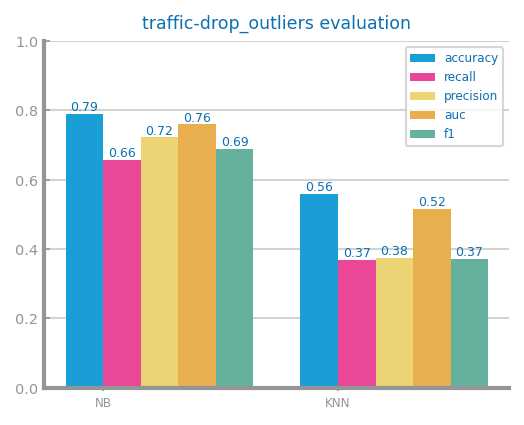

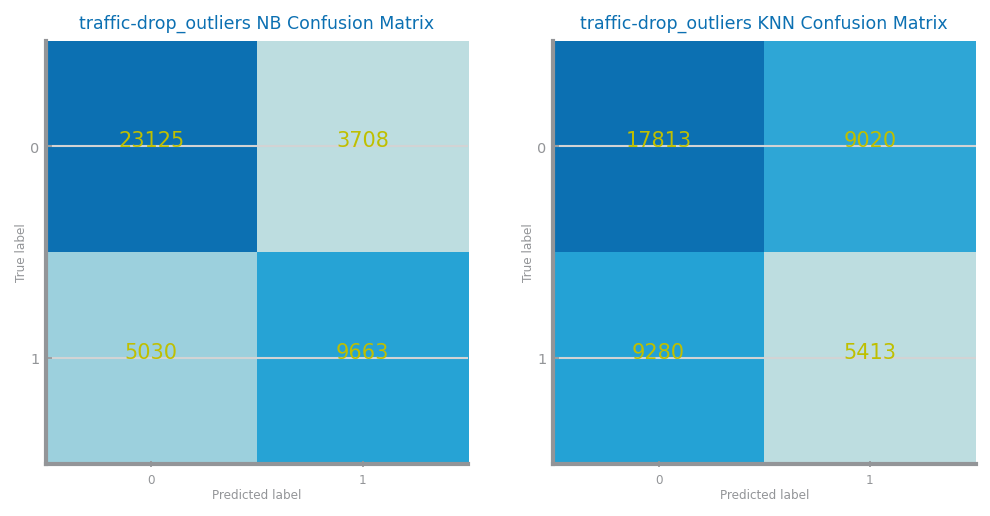

In [5]:
evaluate_and_plot(df_out1, lab_folder_out, file_tag, approach_out1, target_name)

### Approach 2 ###

In [6]:
approach_out2 = "replacing_outliers"

In [7]:
if [] != numeric_vars:
    df_out2: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df_out2[var].median()
        df_out2[var] = df_out2[var].apply(lambda x: median if x > top or x < bottom else x)
    df_out2.to_csv(f"../../data/prepared/{file_tag}_{approach_out2}.csv", index=True)
    print("Data after replacing outliers:", df_out2.shape)
    print(df_out2.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.609386e+18       0.439213                0.952309       1.803111   
std    7.425389e+16       0.496292                0.213112       0.397649   
min    1.454883e+18       0.000000                0.000000       1.000000   
25%    1.546545e+18       0.000000                1.000000       2.000000   
50%    1.608397e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

       num_units  most_severe_injury  injuries_total  injuries_fatal  \
count   209306.0       209306.000000   209306.000000        209306.0   
mean         2.0            0.378054        0.183358             0.0   
std          0.0            0.732383        0

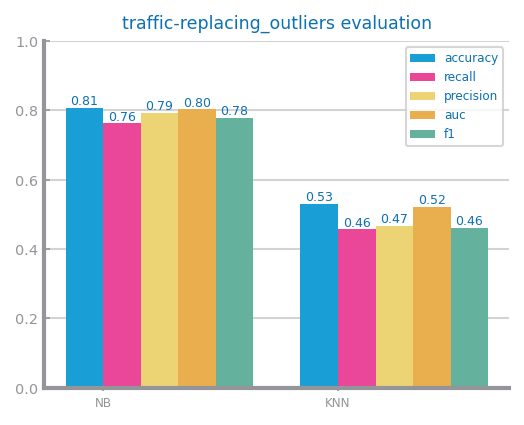

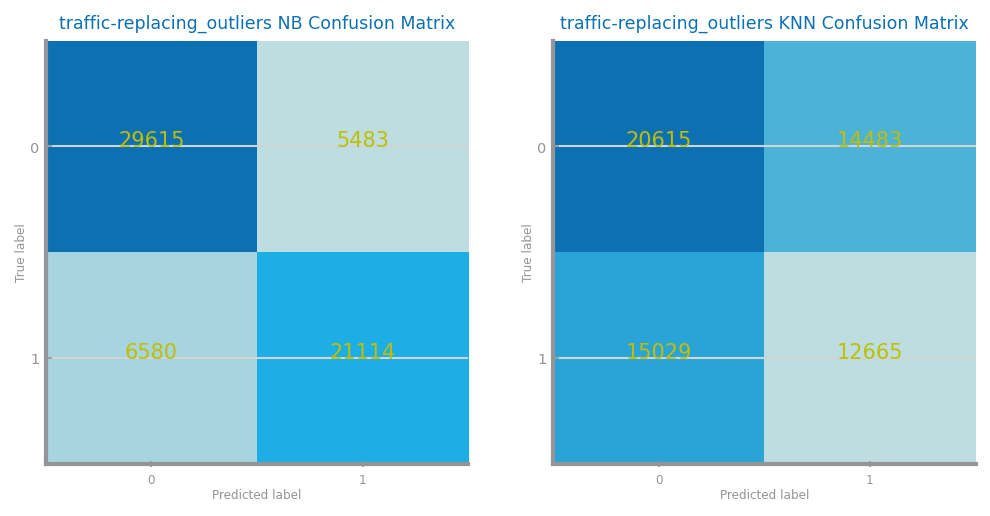

In [8]:
evaluate_and_plot(df_out2, lab_folder_out, file_tag, approach_out2, target_name)

### Approach 3 ###

In [9]:
approach_out3 = "truncate_outliers"

In [10]:
if [] != numeric_vars:
    df_out3: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df_out3[var] = df_out3[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df_out3.to_csv(f"../../data/prepared/{file_tag}_{approach_out3}.csv", index=True)
    print("Data after truncating outliers:", df_out3.shape)
    print(df_out3.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.607552e+18       0.439213                0.952309       1.632463   
std    7.612836e+16       0.496292                0.213112       0.595890   
min    1.454876e+18       0.000000                0.000000       0.281394   
25%    1.543832e+18       0.000000                1.000000       1.000000   
50%    1.608396e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

           num_units  most_severe_injury  injuries_total  injuries_fatal  \
count  209306.000000       209306.000000   209306.000000   209306.000000   
mean        2.042713            0.451443        0.336197        0.000162   
std         0.250924            

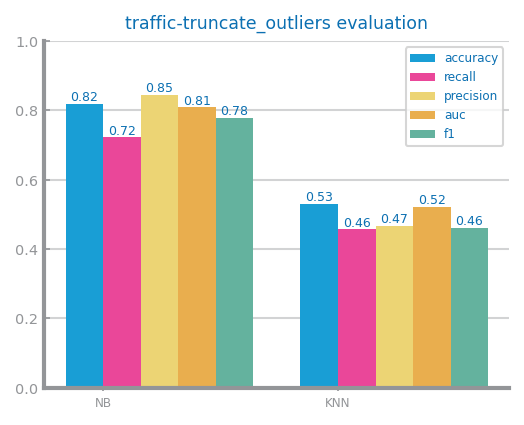

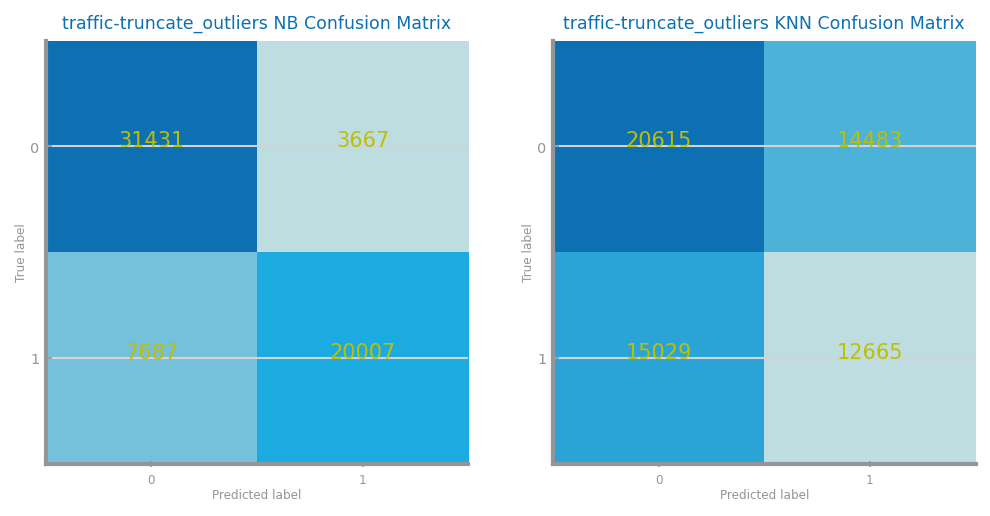

In [11]:
evaluate_and_plot(df_out3, lab_folder_out, file_tag, approach_out3, target_name)

### **Scaling** ###

In [12]:
lab_folder_sca = "lab3_preparation/scaling"

# filename = "../../data/prepared/traffic_outliers_drop_outliers.csv"
# filename = "../../data/prepared/traffic_outliers_replacing_outliers.csv"
# filename = "../../data/prepared/traffic_outliers_truncate_outliers.csv"

input_df = df_out3.copy()

In [13]:
filename_raw = "../../data/raw/traffic_accidents.csv"
df_raw: DataFrame = read_csv(filename_raw, na_values="")
variable_types: dict[str, list] = get_variable_types(df_raw)

In [14]:
numeric_vars = variable_types['numeric']
df_raw[numeric_vars].head()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,2,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,2,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,3,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,2,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,2,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [15]:
symbolic_vars = variable_types['symbolic']
df_raw[symbolic_vars].head()

,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,damage,prim_contributory_cause,most_severe_injury
0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,"$501 - $1,500",UNABLE TO DETERMINE,NO INDICATION OF INJURY
1,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,NO INDICATION OF INJURY
2,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"$501 - $1,500",FOLLOWING TOO CLOSELY,NO INDICATION OF INJURY
3,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",UNABLE TO DETERMINE,NONINCAPACITATING INJURY
4,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,"$501 - $1,500",DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NO INDICATION OF INJURY


### Approach 1 - Standard Scaler

In [16]:
approach_sca1 = "Standard-Scaler"

data_sca1 = input_df.copy()
target: Series = data_sca1.pop(target_name)

numeric_df = data_sca1[numeric_vars].copy()
transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    numeric_df
)
numeric_df_scaled = DataFrame(transf.transform(numeric_df), index=data_sca1.index)
data_sca1[numeric_vars] = numeric_df_scaled
data_sca1[target_name] = target

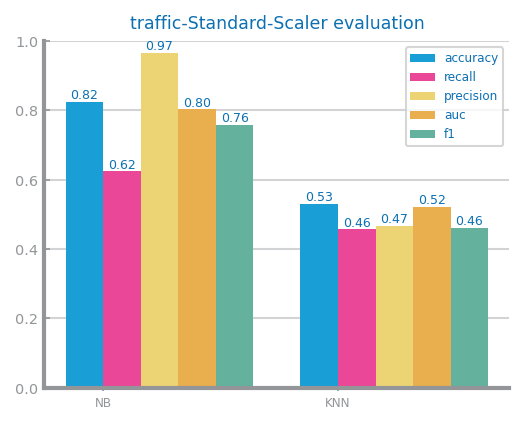

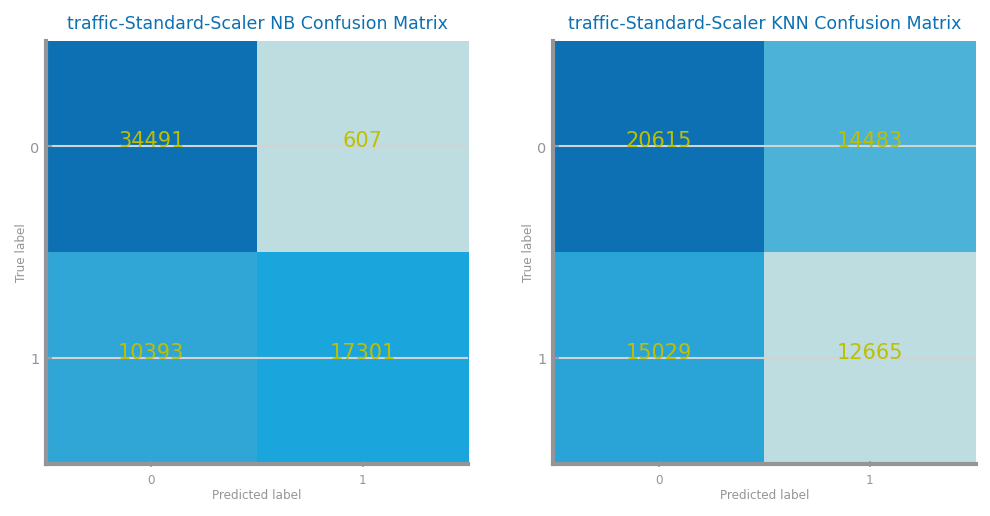

In [17]:
evaluate_and_plot(data_sca1, lab_folder_sca, file_tag, approach_sca1, target_name)

### Approach 2 - MinMax Scaler

In [18]:
approach_sca2 = "MinMax-Scaler"

data_sca2 = input_df.copy()
target: Series = data_sca2.pop(target_name)

numeric_df = data_sca2[numeric_vars].copy()
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(numeric_df)
numeric_df_scaled = DataFrame(transf.transform(numeric_df), index=data_sca2.index)
data_sca2[numeric_vars] = numeric_df_scaled
data_sca2[target_name] = target

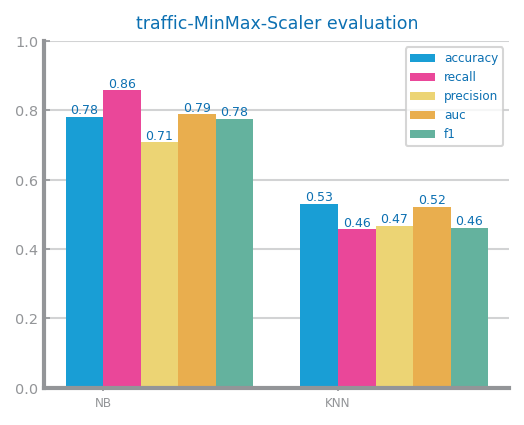

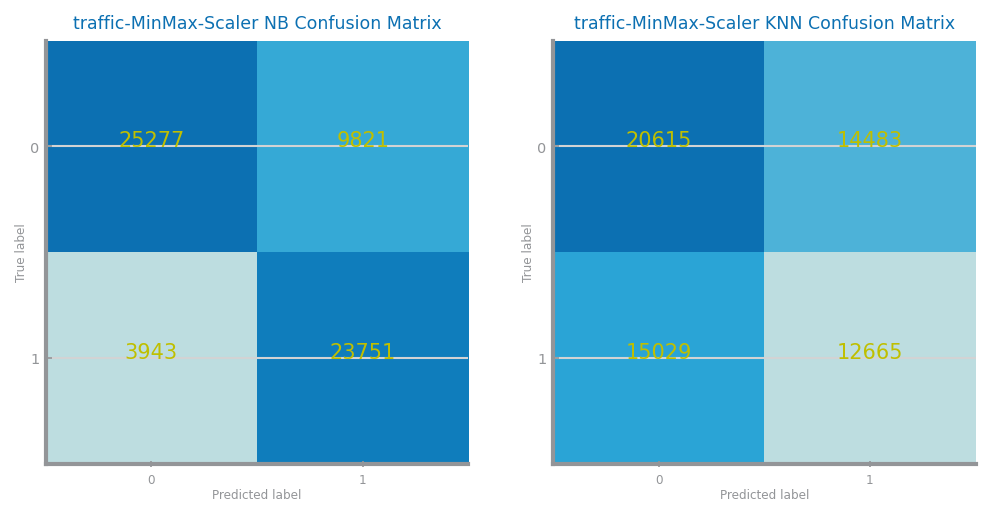

In [19]:
evaluate_and_plot(data_sca2, lab_folder_sca, file_tag, approach_sca2, target_name)

### **Balancing** ###

In [20]:
lab_folder_bal = "lab3_preparation/balancing"

# filename = "../../data/prepared/traffic_outliers_drop_outliers.csv"
# filename = "../../data/prepared/traffic_outliers_replacing_outliers.csv"
# filename = "../../data/prepared/traffic_outliers_truncate_outliers.csv"

#input_df = data_sca1.copy()
input_df = data_sca2.copy()

### Approach 1 - Undersampling

In [21]:
approach_bal1 = "undersampling"

# Check class distribution before balancing
print("Class distribution before undersampling:")
print(input_df[target_name].value_counts())
print(f"Ratio: {input_df[target_name].value_counts()[0] / input_df[target_name].value_counts()[1]:.2f}:1")

# Separate majority and minority classes
df_majority = input_df[input_df[target_name] == 0]
df_minority = input_df[input_df[target_name] == 1]

# Undersample majority class to match minority class size
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with undersampled majority class
data_bal1 = concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
data_bal1 = data_bal1.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nClass distribution after undersampling:")
print(data_bal1[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal1)} ({100*len(data_bal1)/len(input_df):.1f}%)")

Class distribution before undersampling:
crash_type
0    117376
1     91930
Name: count, dtype: int64
Ratio: 1.28:1

Class distribution after undersampling:
crash_type
1    91930
0    91930
Name: count, dtype: int64
Dataset size: 209306 → 183860 (87.8%)


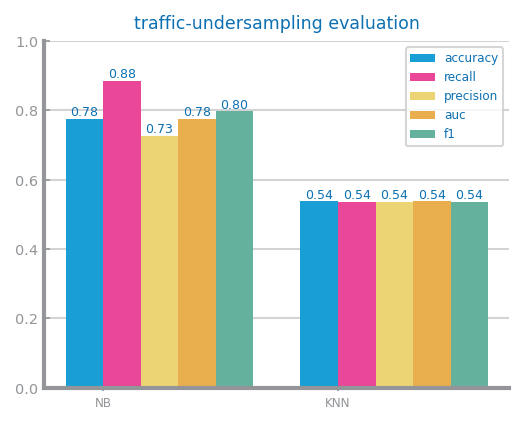

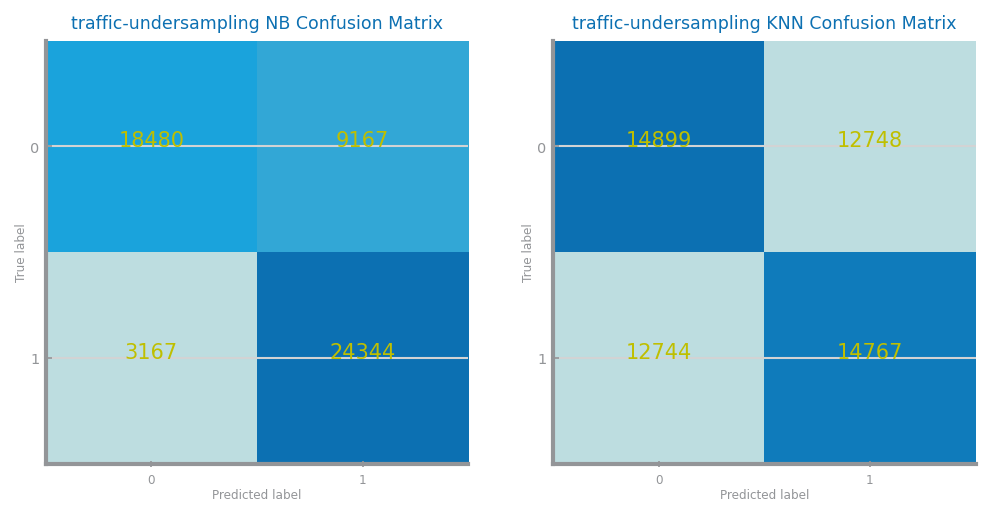

In [22]:
# Evaluate
evaluate_and_plot(data_bal1, lab_folder_bal, file_tag, approach_bal1, target_name)

### Approach 2 - SMOTE (Synthetic Minority Over-sampling Technique)

In [23]:
approach_bal2 = "SMOTE"

# Check class distribution before balancing
print("Class distribution before SMOTE:")
print(input_df[target_name].value_counts())

# Separate features and target
X = input_df.drop(columns=[target_name])
y = input_df[target_name]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into DataFrame
data_bal2 = DataFrame(X_resampled, columns=X.columns)
data_bal2[target_name] = y_resampled

print(f"\nClass distribution after SMOTE:")
print(data_bal2[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal2)} ({100*len(data_bal2)/len(input_df):.1f}%)")

Class distribution before SMOTE:
crash_type
0    117376
1     91930
Name: count, dtype: int64

Class distribution after SMOTE:
crash_type
0    117376
1    117376
Name: count, dtype: int64
Dataset size: 209306 → 234752 (112.2%)


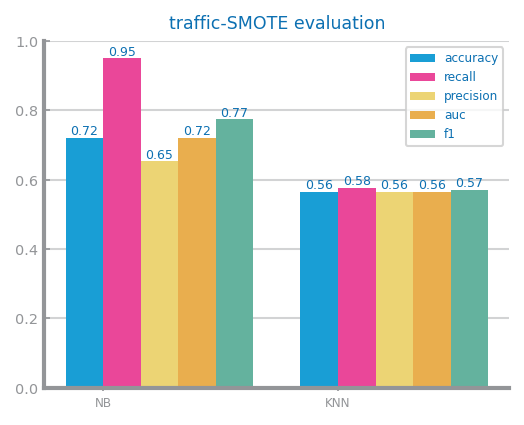

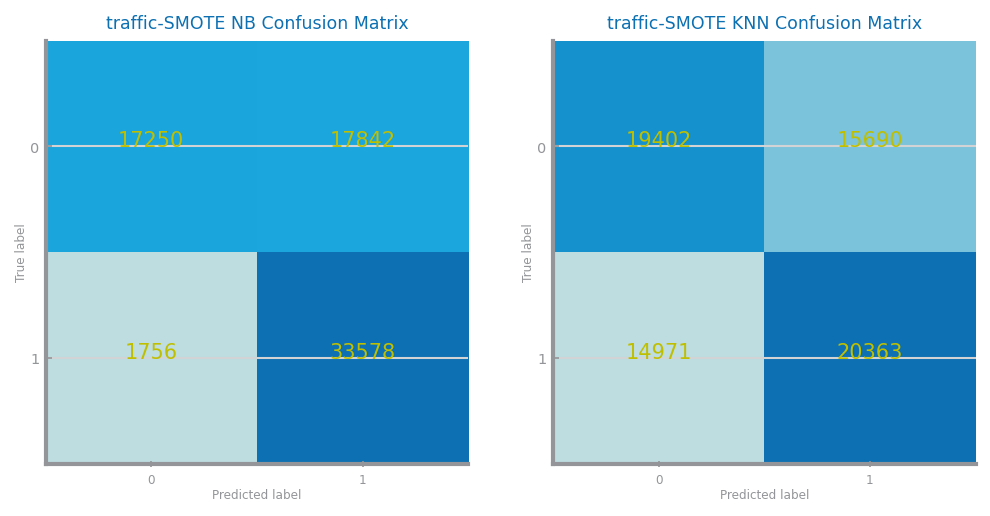

In [24]:
# Evaluate
evaluate_and_plot(data_bal2, lab_folder_bal, file_tag, approach_bal2, target_name)